## Check: Heff for qubit 0 off-resonant drive

In [28]:
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.06}}

coeffs = find_heff(
    qubits=0,
    params=params_orig,
    drive_def=drive_def,
    num_sim_levels=2,
    comp_dim=2,
    save_result_to='test',
    log_level=logging.INFO)

coeffs

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 2 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 32218187482.363426 and envelope 0.06
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.021e-06
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.883484 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to test.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 142 steps.


array([      0.        ,  282599.8125    ,  -27556.09960938,
       3658773.25      ])

In [29]:
with h5py.File('test.h5', 'r') as source:
    time_evolution = source['time_evolution'][:]
    tlist = source['tlist'][:]

time_evolution.shape

(1000, 2, 2)

In [30]:
generators = matrix_ufunc(lambda u: -np.angle(u), time_evolution)
coeffs_t = extract_coefficients(generators, 2, 1)

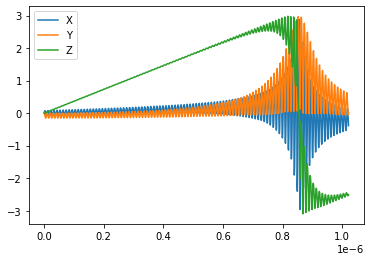

In [31]:
plt.plot(tlist, coeffs_t[:, 1], label='X')
plt.plot(tlist, coeffs_t[:, 2], label='Y')
plt.plot(tlist, coeffs_t[:, 3], label='Z')
plt.legend()

## Check: Heff for cross resonance

In [32]:
params = dict(params_orig)
params['crosstalk'] = {(0, 1): 0.8 * np.exp(-np.pi / 4. * 1.j)}
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.01}}

coeffs = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=2,
    comp_dim=2,
    save_result_to='test_cr',
    log_level=logging.INFO)

coeffs

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 2 qubits and 2 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 2
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 32218187482.363426 and envelope 0.01
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.021e-06
INFO:qudit_sim.pulse_sim:Hamiltonian with 5 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.888409 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to test_cr.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 77 steps.


array([[ 0.00000000e+00,  8.98462500e+06, -8.98487700e+06,
        -1.98848969e+05],
       [ 7.69548633e+03, -1.85096375e+03,  1.62795020e+04,
         7.64502891e+04],
       [-3.75118125e+04, -2.08707168e+04,  1.04073857e+04,
        -8.21936719e+04],
       [ 4.05081750e+05,  2.87278781e+05,  4.05401855e+02,
        -3.30956909e+03]])

In [33]:
with h5py.File('test_cr.h5', 'r') as source:
    time_evolution = source['time_evolution'][:]
    tlist = source['tlist'][:]

time_evolution.shape

(1000, 4, 4)

In [34]:
generators = matrix_ufunc(lambda u: -np.angle(u), time_evolution)
coeffs_t = extract_coefficients(generators, 2, 2)

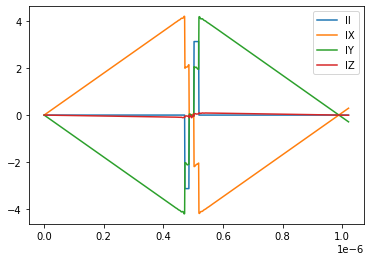

In [35]:
plt.plot(tlist, coeffs_t[:, 0, 0], label='II')
plt.plot(tlist, coeffs_t[:, 0, 1], label='IX')
plt.plot(tlist, coeffs_t[:, 0, 2], label='IY')
plt.plot(tlist, coeffs_t[:, 0, 3], label='IZ')
plt.legend()

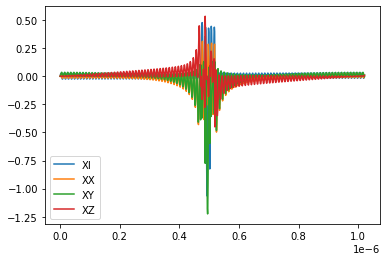

In [36]:
plt.plot(tlist, coeffs_t[:, 1, 0], label='XI')
plt.plot(tlist, coeffs_t[:, 1, 1], label='XX')
plt.plot(tlist, coeffs_t[:, 1, 2], label='XY')
plt.plot(tlist, coeffs_t[:, 1, 3], label='XZ')
plt.legend()

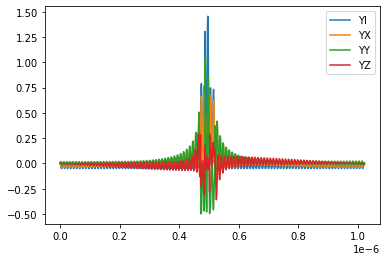

In [37]:
plt.plot(tlist, coeffs_t[:, 2, 0], label='YI')
plt.plot(tlist, coeffs_t[:, 2, 1], label='YX')
plt.plot(tlist, coeffs_t[:, 2, 2], label='YY')
plt.plot(tlist, coeffs_t[:, 2, 3], label='YZ')
plt.legend()

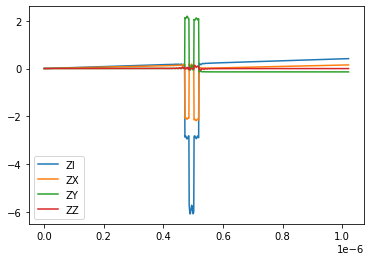

In [38]:
plt.plot(tlist, coeffs_t[:, 3, 0], label='ZI')
plt.plot(tlist, coeffs_t[:, 3, 1], label='ZX')
plt.plot(tlist, coeffs_t[:, 3, 2], label='ZY')
plt.plot(tlist, coeffs_t[:, 3, 3], label='ZZ')
plt.legend()